In [1]:
library(ggplot2)
library(cowplot)
library(vegan)
library(dunn.test)
library(ggsignif)
library(eulerr)
library(ape)
library(UpSetR)
library(grid)
library(gridGraphics)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-2

Attaching package: ‘UpSetR’

The following object is masked from ‘package:lattice’:

    histogram



In [2]:
asv_tab <- read.table("data/asv_table.tab", comment.char="", header=1, skip=1, sep="\t", row.names=1)
pd <- read.table("data/faith_pd_vector.tsv", sep="\t", header=1)
md <- read.table("data/METADATA.txt", header=1, comment.char="", sep="\t", row.names=1)
taxonomy <- read.table("data/taxonomy.tsv", sep="\t", header=1, row.names=1)

colnames(pd) <- c("SampleID", "PD")
pd$Location <- md[as.character(pd$SampleID),"location"]
pd$Location <- as.factor(pd$Location)
levels(pd$Location) <- c("Palmetto Inland (n=6)", "Palmetto Coast (n=6)", "Vero Beach (n=4)")
#Swap the order
pd$Location <- factor(pd$Location,levels(pd$Location)[c(2,1,3)])

In [3]:
cut_taxonomy_string <- function(x, n) {
    sp <- unlist(strsplit(x,";"))
    if (length(sp) >= n) {
        return(gsub('D_[0-7]__', '', sp[n]))
        }
    else {
        return(gsub('D_[0-7]__', '', sp[length(sp)]))
    }
}

In [4]:
#Number of ASVs by number of samples
dim(asv_tab)
#Number of sequences per sample
colSums(asv_tab)
#Total number of sequences
sum(asv_tab)
#Slice and dice the number of ASVs by taxonomy
for (rank in 1:2) {
print(table(
    unlist(
        lapply(as.character(taxonomy$Taxon), 
               function(x) cut_taxonomy_string(x, rank)))))
               }

[1] 1482   16

X54    X55    X56    X57    X82    X83    X84    X85    X86    X87    X88 
 71696  80279  81858  93616  31183 107296 113549  69986  69962  84366  97138 
   X89    X90    X91    X95    X96 
 77591  70636 127379 209234 197453

[1] 1583222


   Archaea   Bacteria  Eukaryota Unassigned 
         2       1198         25        257 

     Acidobacteria     Actinobacteria            Archaea     Archaeplastida 
                40                173                  1                  1 
          Bacteria      Bacteroidetes               BRC1         Chlamydiae 
                64                 58                  1                  1 
       Chloroflexi      Cyanobacteria       Dependentiae  Entotheonellaeota 
                 9                 21                  2                  1 
Epsilonbacteraeota          Eukaryota         Firmicutes   Gemmatimonadetes 
                 4                 23                121                  6 
   Latescibacteria    Nanoarchaeaeota        Nitrospirae       Opisthokonta 
                 1                  1                  1                  1 
   Patescibacteria     Planctomycetes     Proteobacteria       Rokubacteria 
                18                  9                613     

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 7.5478, df = 2, p-value = 0.02


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Palmetto   Palmetto
---------+----------------------
Palmetto |   1.030776
         |     0.3026
         |
Vero Bea |   2.738747   1.816792
         |    0.0185*     0.1039

alpha = 0.05
Reject Ho if p <= alpha
$chi2
[1] 7.547794

$Z
[1] 1.030776 2.738747 1.816793

$altP
[1] 0.302645685 0.006167381 0.069248879

$altP.adjusted
[1] 0.30264568 0.01850214 0.10387332

$comparisons
[1] "Palmetto Coast (n=6) - Palmetto Inland (n=6)"
[2] "Palmetto Coast (n=6) - Vero Beach (n=4)"     
[3] "Palmetto Inland (n=6) - Vero Beach (n=4)"    



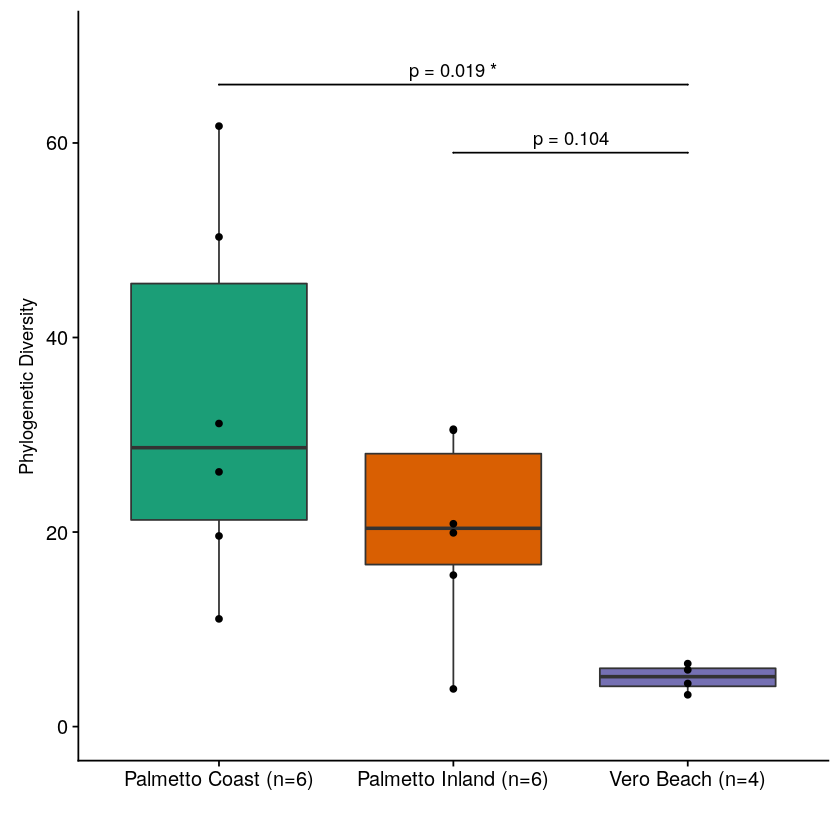

In [5]:
dt <- dunn.test(pd$PD, pd$Location, method='bh', altp=TRUE)
print(dt)
ad <- ggplot(pd, aes(x=Location, group=Location, y=PD, fill=Location)) + geom_boxplot() +
      geom_signif(y_position=c(66, 59), xmin=c(1, 2), xmax=c(3, 3),
                  annotation=c(paste("p =",round(dt$altP.adjusted[2], 3),"*"), 
                               paste("p =",round(dt$altP.adjusted[3], 3))), tip_length=0) + 
      geom_point() +
      scale_fill_brewer(palette='Dark2') + 
      theme(legend.position='none', axis.title.y=element_text(size=11)) + 
      ylab("Phylogenetic Diversity") +
      xlab("") + ylim(c(0,70))

ad

In [6]:
plot_ordination <- function(ord) {
    md.vars <- md[gsub('X','',colnames(asv_tab)),]
    md.vars$location <- as.factor(md.vars$location)
    levels(md.vars$location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")

    md.tax <- taxonomy[rownames(asv_tab),]
    topn <- 10
    top <- match(as.character(names(rowSums(asv_tab)[1:topn])), as.character(rownames(asv_tab)))
    tax_labels <- unlist(
                  lapply(as.character(
                         taxonomy[names(rowSums(asv_tab)[1:topn]), 'Taxon']
                         ), 
                        function(x) cut_taxonomy_string(x, 7)
                        )
                        )
    plot(ord, display='sites')
    ordilabel(ord, display = "spec", cex=0.45, col="black", border=FALSE, select=top, labels=tax_labels, xpd = FALSE)
    ordispider(ord, md.vars$location, col=c("#d95f02","#1b9e77","#7570b3"), label=FALSE)
    ordiellipse(ord, md.vars$location, col=c("#d95f02","#1b9e77","#7570b3"), draw='polygon')
}

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1849418 
Run 1 stress 0.2428618 
Run 2 stress 0.1849418 
... Procrustes: rmse 4.85116e-05  max resid 0.0001174396 
... Similar to previous best
Run 3 stress 0.1905837 
Run 4 stress 0.2595076 
Run 5 stress 0.2367179 
Run 6 stress 0.1854416 
... Procrustes: rmse 0.04707812  max resid 0.1148872 
Run 7 stress 0.1909604 
Run 8 stress 0.2529216 
Run 9 stress 0.1849418 
... New best solution
... Procrustes: rmse 2.105053e-06  max resid 4.820402e-06 
... Similar to previous best
Run 10 stress 0.1909605 
Run 11 stress 0.1854416 
... Procrustes: rmse 0.04709917  max resid 0.1149104 
Run 12 stress 0.1849418 
... Procrustes: rmse 3.572147e-06  max resid 6.596022e-06 
... Similar to previous best
Run 13 stress 0.2360785 
Run 14 stress 0.1912258 
Run 15 stress 0.1909601 
Run 16 stress 0.1854416 
... Procrustes: rmse 0.04709065  max resid 0.1149113 
Run 17 stress 0.1909601 
Run 18 stress 0.1955653 
Run 19 stress 0.1905841 
Run

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


Call:
metaMDS(comm = t(asv_tab), distance = "bray", binary = TRUE) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(t(asv_tab))) 
Distance: binary bray 

Dimensions: 2 
Stress:     0.1849418 
Stress type 1, weak ties
Two convergent solutions found after 20 tries
Scaling: centring, PC rotation 
Species: expanded scores based on ‘wisconsin(sqrt(t(asv_tab)))’ 


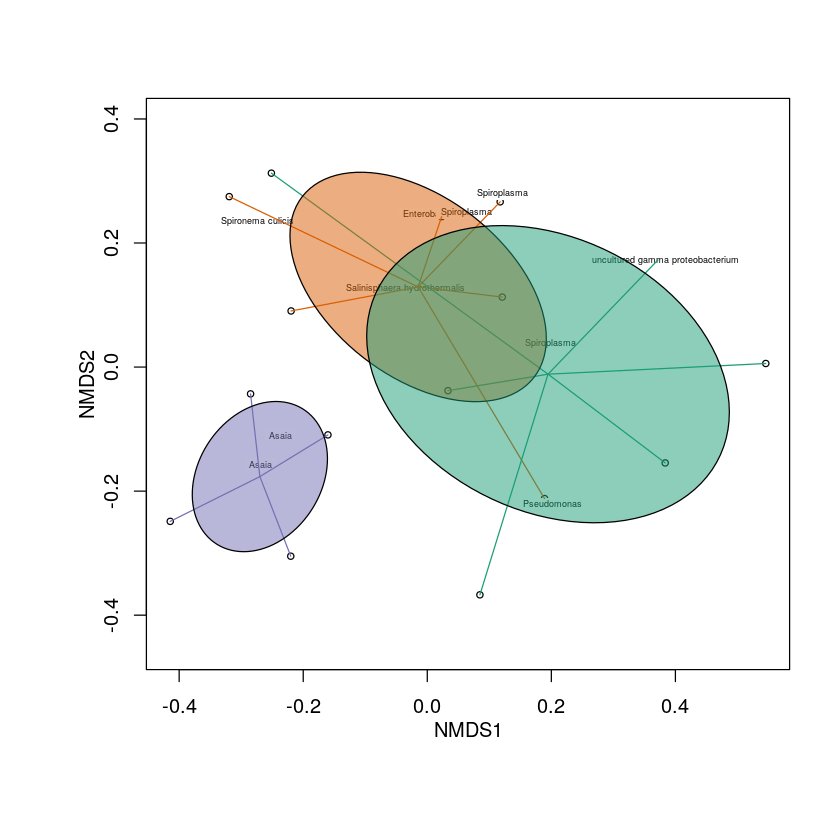

In [7]:
par(xpd = NA, # switch off clipping, necessary to always see axis labels
    bg = "transparent", # switch off background to avoid obscuring adjacent plots
    oma = c(2, 2, 0, 0), # move plot to the right and up
    mgp = c(2, 1, 0) # move axis labels closer to axis
)
uwb <- metaMDS(t(asv_tab), dist='bray', binary=TRUE)
uwb
plot_ordination(uwb)
puwb <- recordPlot()

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1792614 
Run 1 stress 0.3009051 
Run 2 stress 0.1792614 
... New best solution
... Procrustes: rmse 9.810983e-06  max resid 1.734839e-05 
... Similar to previous best
Run 3 stress 0.2791565 
Run 4 stress 0.1792614 
... Procrustes: rmse 1.131367e-05  max resid 2.357141e-05 
... Similar to previous best
Run 5 stress 0.1937569 
Run 6 stress 0.2710364 
Run 7 stress 0.1937569 
Run 8 stress 0.1993312 
Run 9 stress 0.2348534 
Run 10 stress 0.2513795 
Run 11 stress 0.193757 
Run 12 stress 0.1937569 
Run 13 stress 0.1792614 
... New best solution
... Procrustes: rmse 6.25937e-06  max resid 1.149983e-05 
... Similar to previous best
Run 14 stress 0.2448401 
Run 15 stress 0.2502689 
Run 16 stress 0.3479615 
Run 17 stress 0.1792614 
... New best solution
... Procrustes: rmse 5.255686e-06  max resid 1.037637e-05 
... Similar to previous best
Run 18 stress 0.2448392 
Run 19 stress 0.1792615 
... Procrustes: rmse 4.146336e-05 

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


Call:
metaMDS(comm = t(asv_tab), distance = "bray", binary = FALSE) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(t(asv_tab))) 
Distance: bray 

Dimensions: 2 
Stress:     0.1792614 
Stress type 1, weak ties
Two convergent solutions found after 20 tries
Scaling: centring, PC rotation 
Species: expanded scores based on ‘wisconsin(sqrt(t(asv_tab)))’ 


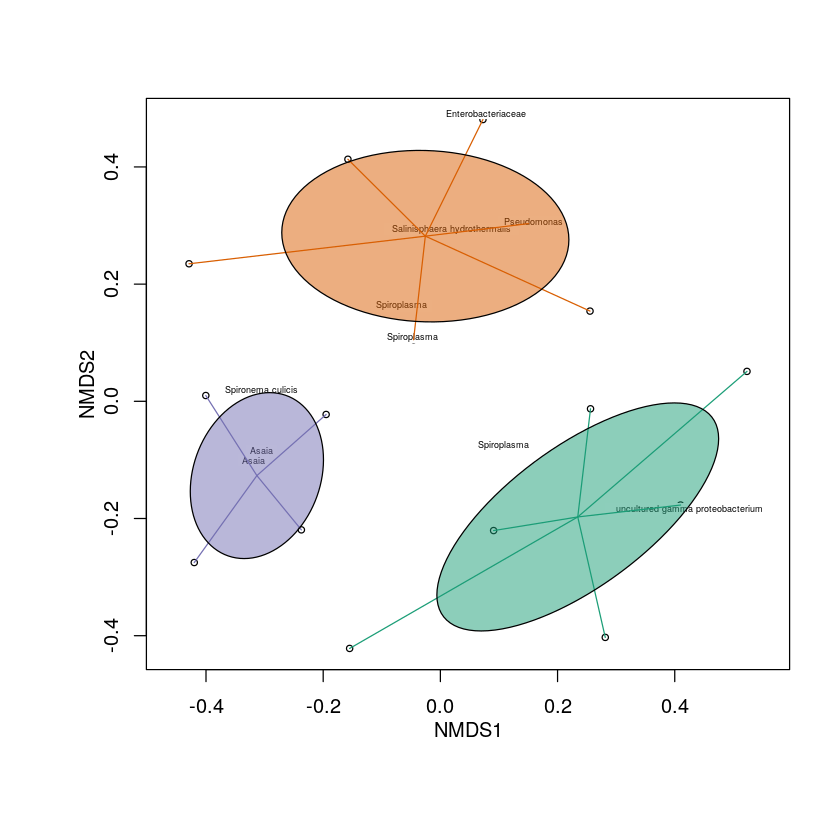

In [8]:
par(xpd = NA, # switch off clipping, necessary to always see axis labels
    bg = "transparent", # switch off background to avoid obscuring adjacent plots
    oma = c(2, 2, 0, 0), # move plot to the right and up
    mgp = c(2, 1, 0) # move axis labels closer to axis
)
wb <- metaMDS(t(asv_tab), dist='bray', binary=FALSE)
wb
plot_ordination(wb)
pwb <- recordPlot()

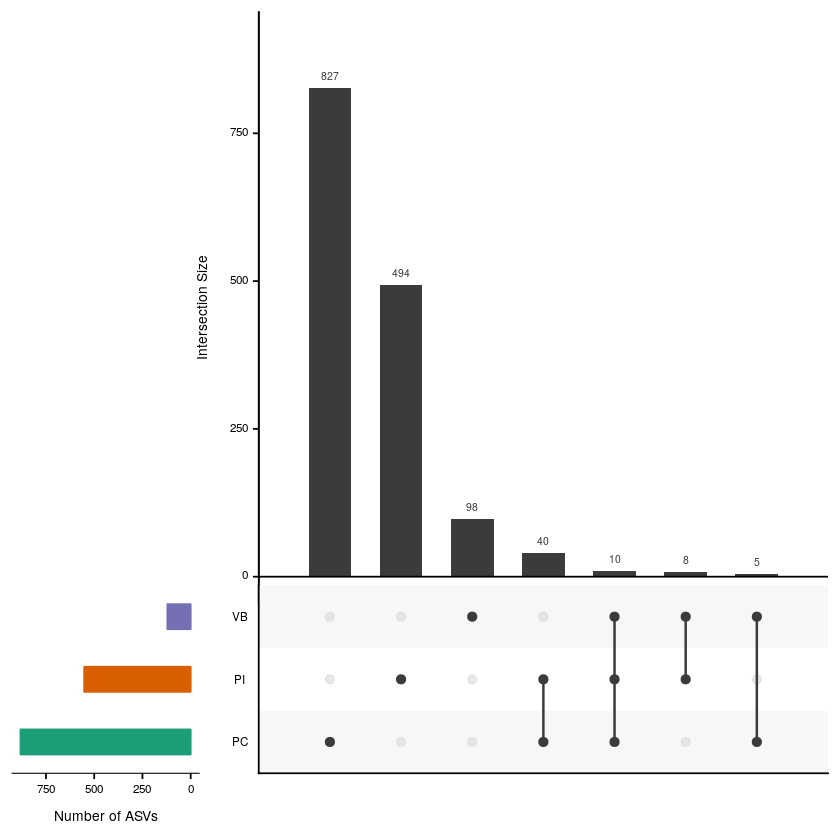

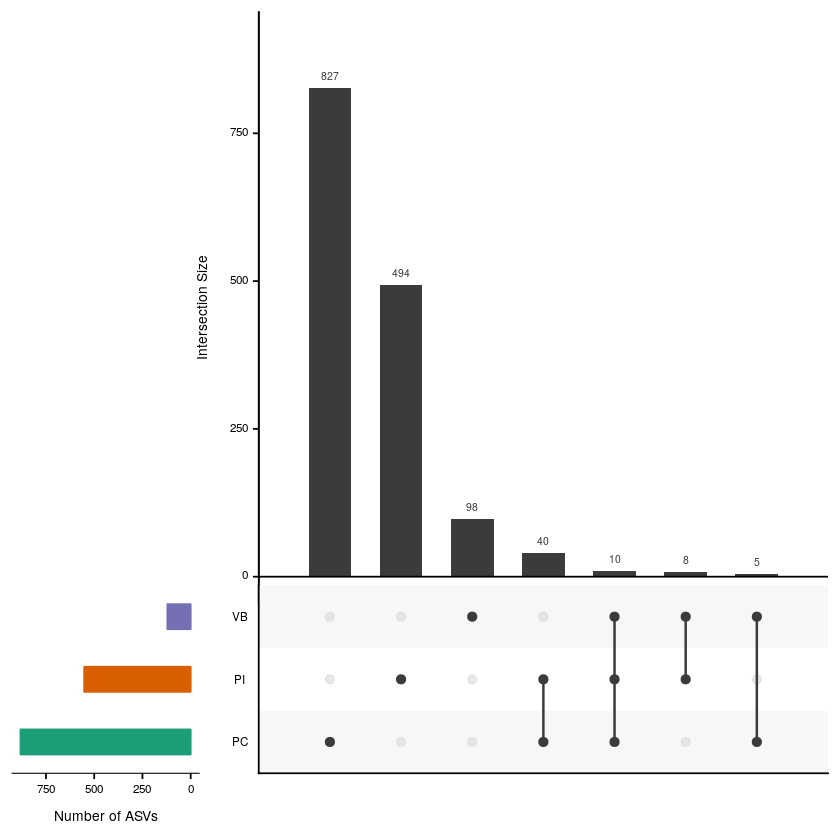

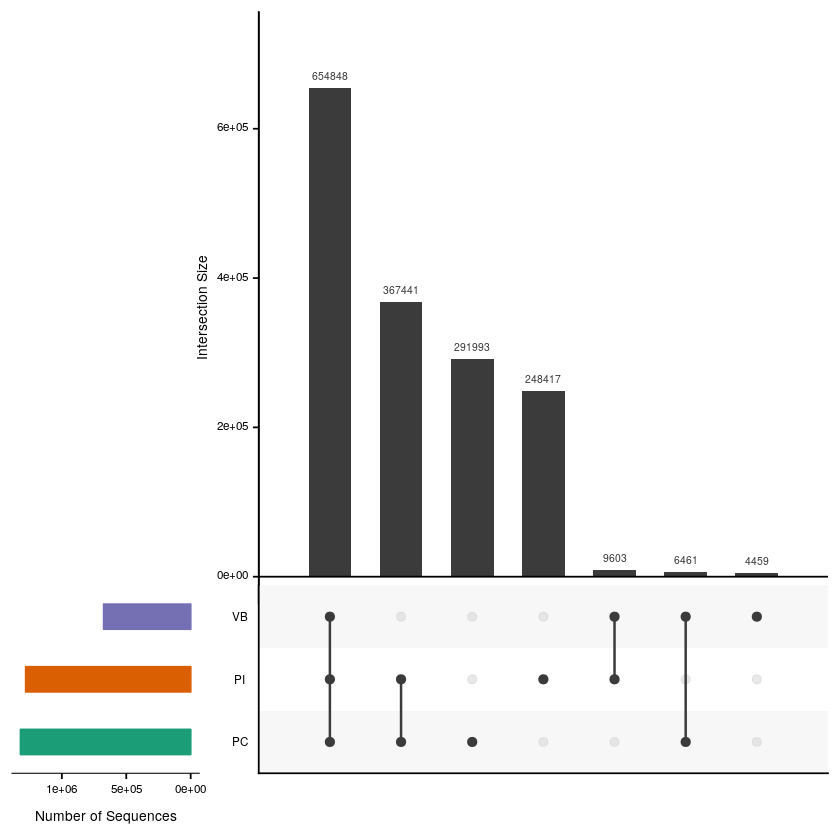

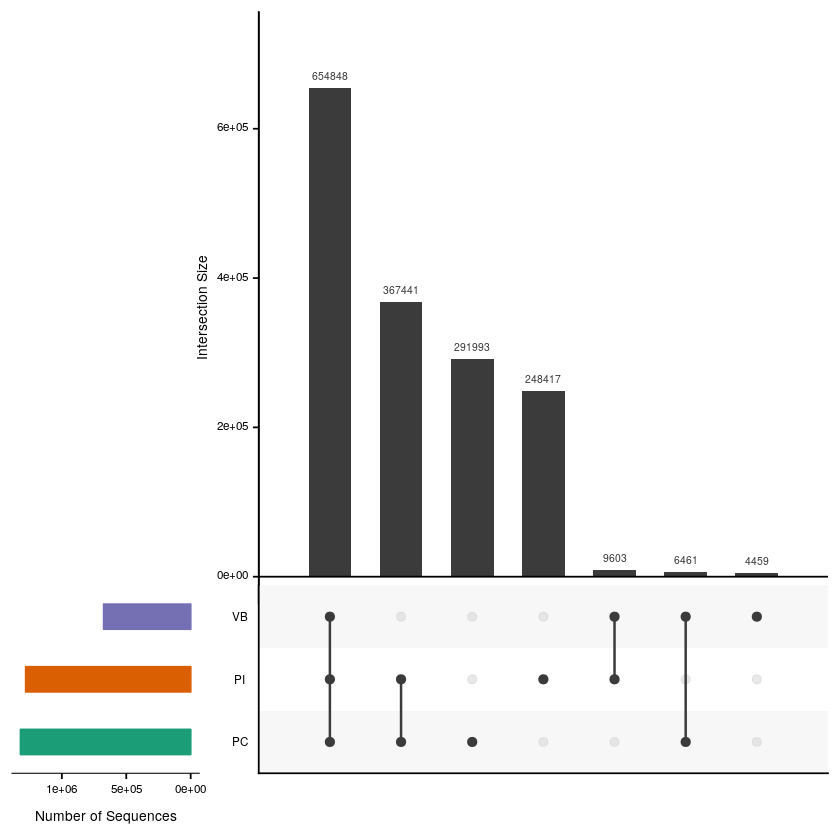

In [9]:
options(plot.repr.width=5, plot.repr.height=4)
count_intersections <- function(weighted=FALSE) {
    atab <- t(asv_tab)
    md.vars <- md[gsub('X','',colnames(asv_tab)),]
    md.vars$location <- as.factor(md.vars$location)
    levels(md.vars$location) <- c("Palmetto Inland", "Palmetto Coast", "Vero Beach")
    atab <- as.data.frame(atab)
    atab$location <- as.vector(md[gsub('X','',rownames(atab)),'location'])
    loc.agg.tab <- aggregate(.~location, atab, sum)
    counts <- c(PI=0,PC=0,VB=0,"PI&PC"=0,"PI&VB"=0,"PC&VB"=0,"PI&PC&VB"=0)
    for (i in 2:ncol(loc.agg.tab)) {
        col <- loc.agg.tab[,i]
        if (weighted) {
            term <- sum(col)
        } else {
            term <- 1
        }
        if (sum(as.logical(col)) == 3) {
            counts["PI&PC&VB"] <- counts["PI&PC&VB"] + term
        } else if (sum(as.logical(col)) == 2) {
            if (col[1] == 0) {
                counts["PC&VB"] <- counts["PC&VB"] + term
            } else if (col[2] == 0) {
                counts["PI&VB"] <- counts["PI&VB"] + term
            } else if (col[3] == 0) {
                counts["PI&PC"] <- counts["PI&PC"] + term
            } 
        } else {
            if (col[1] != 0) {
                counts["PI"] <- counts["PI"] + term
            } else if (col[2] != 0) {
                counts["PC"] <- counts["PC"] + term
            } else if (col[3] != 0) {
                counts["VB"] <- counts["VB"] + term
            } 
        }
    }
    counts
}
colours <- c(rgb(27,158,119,maxColorValue = 255),  #PC: Green
             rgb(217,95,2,maxColorValue = 255), #PI: Orange
             rgb(117,112,179,maxColorValue = 255)) #VB: Purple
upuw <- upset(fromExpression(count_intersections(weighted=FALSE)),
      order.by='freq', 
      sets.bar.color=colours,
      sets.x.label='Number of ASVs')

upw <- upset(fromExpression(count_intersections(weighted=TRUE)), 
      order.by='freq',
      sets.bar.color=colours,
      sets.x.label='Number of Sequences')

png 
  2

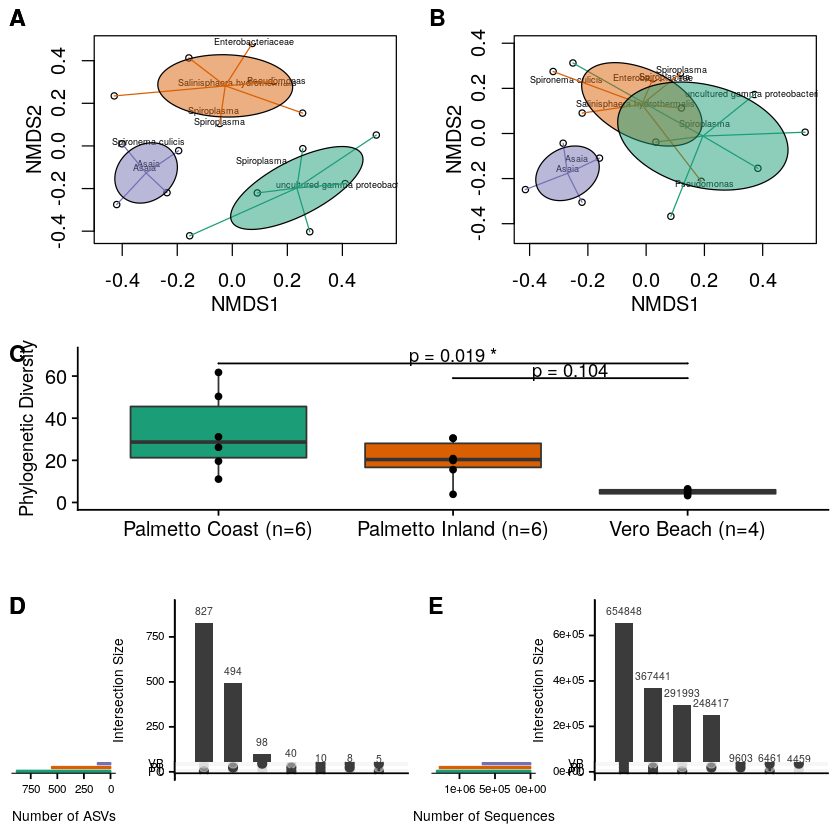

In [10]:
options(plot.repr.width=7, plot.repr.height=10)
pdf("Figure2.pdf", height=10, width=7)
plot_grid(plot_grid(pwb, puwb, ncol=2, labels=c("A","B")), 
          ad, 
          plot_grid(upuw, upw, ncol=2, labels=c("D","E")), ncol=1, labels=c("A","C","D"),
          rel_heights=c(1,0.75,0.75))
dev.off()
plot_grid(plot_grid(pwb, puwb, ncol=2, labels=c("A","B")), 
          ad, 
          plot_grid(upuw, upw, ncol=2, labels=c("D","E")), ncol=1, labels=c("A","C","D"),
          rel_heights=c(1,0.75,0.75))

In [11]:
print(dt)

$chi2
[1] 7.547794

$Z
[1] 1.030776 2.738747 1.816793

$altP
[1] 0.302645685 0.006167381 0.069248879

$altP.adjusted
[1] 0.30264568 0.01850214 0.10387332

$comparisons
[1] "Palmetto Coast (n=6) - Palmetto Inland (n=6)"
[2] "Palmetto Coast (n=6) - Vero Beach (n=4)"     
[3] "Palmetto Inland (n=6) - Vero Beach (n=4)"    



In [12]:
#Just for posterity, this was used in the manuscript before a reviewer suggestion for the above test
pairwise.wilcox.test(pd$PD, pd$Location, p.adj='BH')


	Pairwise comparisons using Wilcoxon rank sum test 

data:  pd$PD and pd$Location 

                      Palmetto Coast (n=6) Palmetto Inland (n=6)
Palmetto Inland (n=6) 0.310                -                    
Vero Beach (n=4)      0.029                0.100                

P value adjustment method: BH 

In [13]:
mrpp(vegdist(t(asv_tab), distance='bray', binary=TRUE), md[gsub('X','',colnames(asv_tab)),'location'])


Call:
mrpp(dat = vegdist(t(asv_tab), distance = "bray", binary = TRUE),      grouping = md[gsub("X", "", colnames(asv_tab)), "location"]) 

Dissimilarity index: binary bray 
Weights for groups:  n 

Class means and counts:

      B1GF (-82.49683333 27.62796667) B1P (-82.5526666666666, 27.64048333)
delta 0.9223                          0.9491                              
n     6                               6                                   
      Vero Beach 
delta 0.7043     
n     4          

Chance corrected within-group agreement A: 0.06142 
Based on observed delta 0.8778 and expected delta 0.9353 

Significance of delta: 0.001 
Permutation: free
Number of permutations: 999


In [14]:
mrpp(vegdist(t(asv_tab), distance='bray', binary=FALSE), md[gsub('X','',colnames(asv_tab)),'location'])


Call:
mrpp(dat = vegdist(t(asv_tab), distance = "bray", binary = FALSE),      grouping = md[gsub("X", "", colnames(asv_tab)), "location"]) 

Dissimilarity index: bray 
Weights for groups:  n 

Class means and counts:

      B1GF (-82.49683333 27.62796667) B1P (-82.5526666666666, 27.64048333)
delta 0.9215                          0.9625                              
n     6                               6                                   
      Vero Beach 
delta 0.1711     
n     4          

Chance corrected within-group agreement A: 0.1866 
Based on observed delta 0.7493 and expected delta 0.9211 

Significance of delta: 0.001 
Permutation: free
Number of permutations: 999


In [15]:
rarefy_table <- function(asv_table) {
    raremax <- min(colSums(asv_table))
    rare_table <- asv_table
    for (i in 1:ncol(asv_table)) {
        rare_col <- sample(rownames(asv_table), raremax, replace = TRUE, prob = asv_table[,i])
        rt <- table(rare_col)
        rare_table[! rownames(rare_table) %in% rownames(rt),i] <- 0
        rare_table[rownames(rt),i] <- rt
    }
    rare_table <- rare_table[rowSums(rare_table) != 0, ]
    rare_table
}

rbd <- vegdist(t(rarefy_table(asv_tab)), method='bray', binary=FALSE, diag=TRUE)
brbd <- vegdist(t(rarefy_table(asv_tab)), method='bray', binary=TRUE, diag=TRUE)
bd <- vegdist(t(asv_tab), method='bray', binary=FALSE, diag=TRUE)
bbd <- vegdist(t(asv_tab), method='bray', binary=TRUE, diag=TRUE)
mantel(rbd, bd)
mantel(brbd, bbd)
mantel(bd, bbd)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = rbd, ydis = bd) 

Mantel statistic r: 0.9835 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.123 0.182 0.240 0.278 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = brbd, ydis = bbd) 

Mantel statistic r: 0.9967 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.124 0.186 0.241 0.358 
Permutation: free
Number of permutations: 999



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = bd, ydis = bbd) 

Mantel statistic r: 0.7227 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.131 0.182 0.240 0.334 
Permutation: free
Number of permutations: 999


In [16]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 17.04

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.7.0
LAPACK: /usr/lib/lapack/liblapack.so.3.7.0

locale:
 [1] LC_CTYPE=en_CA.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_CA.UTF-8        LC_COLLATE=en_CA.UTF-8    
 [5] LC_MONETARY=en_CA.UTF-8    LC_MESSAGES=en_CA.UTF-8   
 [7] LC_PAPER=en_CA.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_CA.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gridGraphics_0.3-0 UpSetR_1.3.3       ape_5.1            eulerr_4.1.0      
 [5] ggsignif_0.4.0     dunn.test_1.3.5    vegan_2.5-2        lattice_0.20-34   
 [9] permute_0.9-4      cowplot_0.9.3      ggplot2_3.0.0     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.18        